In [1]:
import pennylane as qml
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dev = qml.device('default.qubit', wires=3)

In [3]:
# two qubit case
def real(angles, **kwargs):
    qml.Hadamard(wires=0)
    qml.RY(np.pi / 4, wires=1)
    qml.RY(np.pi / 4, wires=2)
    qml.RX(np.pi / 4, wires=0)
    qml.CNOT(wires=[0, 1])
    qml.Rot(*angles, wires=0)
    qml.CNOT(wires=[1, 2])
    qml.Rot(*angles, wires=1)

In [4]:
def utheta(w, wires, **kwargs):
    qml.Hadamard(wires=wires[0])
    qml.RX(w[0], wires=wires[0])
    qml.RX(w[1], wires=wires[1])
    qml.RY(w[2], wires=wires[0])
    qml.RY(w[3], wires=wires[1])
    qml.RZ(w[4], wires=wires[0])
    qml.RZ(w[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RX(w[6], wires=wires[0])
    qml.RY(w[7], wires=wires[0])
    qml.RZ(w[8], wires=wires[0])

In [5]:
@qml.qnode(dev, interface="tf")
def qpca(angles, theta_weights, **kwargs):
    real(angles)
    utheta(theta_weights, [0, 1])
    z0 = qml.expval(qml.PauliZ(0))
    z1 = qml.expval(qml.PauliZ(1))
    return z0, z1

In [6]:
def pcaloss(angles, theta_weights, **kwargs):
    z0, z1 = qpca(angles, theta_weights)
    return 1/12 * ((z0 + 1) + 2 * (z1 + 1))

In [7]:
angles = [np.pi / 6, np.pi / 2, np.pi / 7]

np.random.seed(0)
eps = 1e-2
init_theta_weights = np.array([0] + [0] * 8) + \
                   np.random.normal(scale=eps, size=(9,))
theta_weights = tf.Variable(init_theta_weights)

opt = tf.keras.optimizers.SGD(0.4)

In [8]:
@qml.qnode(dev, interface="tf")
def show_real(angles, **kwargs):
    real(angles)
    return qml.density_matrix([0, 1])
real_matrix = show_real(angles).numpy()
U, S, V = np.linalg.svd(real_matrix)
print(S)
minloss = np.sum(S * np.arange(3, -1, -1))/12*2
print(minloss)

[8.53553391e-01 1.46446609e-01 1.11664317e-16 1.38436866e-17]
0.4755922317655456


Step 0: cost = 0.2674711591399931
Step 5: cost = 0.23330251132801583
Step 10: cost = 0.19938552058200298
Step 15: cost = 0.17114781265284562
Step 20: cost = 0.149980061635629
Step 25: cost = 0.13438102674469704
Step 30: cost = 0.12250431942534465
Step 35: cost = 0.11313828675526555
Step 40: cost = 0.10561922267866586
Step 45: cost = 0.0995660539257526
Step 50: cost = 0.09471682895836399
Step 55: cost = 0.0908605112792006
Step 60: cost = 0.08781541553595042
Step 65: cost = 0.08542429933424167
Step 70: cost = 0.08355347655790418
Step 75: cost = 0.08209184846490997
Step 80: cost = 0.08094903342126841
Step 85: cost = 0.08005280965353742
Step 90: cost = 0.07934628268054511
Step 95: cost = 0.07878511502780464
Step 100: cost = 0.07833502440867234
Step 105: cost = 0.07796964294898256
Step 110: cost = 0.07766875300140519
Step 115: cost = 0.07741687153121965
Step 120: cost = 0.07720213550244445
Step 125: cost = 0.07701543592024875
Step 130: cost = 0.07684975129392052
Step 135: cost = 0.076699637

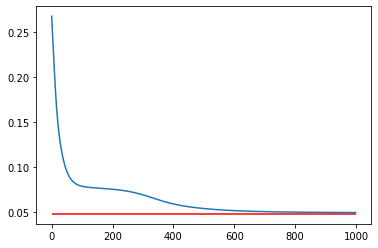

In [9]:
cost = lambda: pcaloss(angles, theta_weights)
n_step = 1000
cost_list = []
for step in range(1000):
    opt.minimize(cost, theta_weights)
    cost_val = cost().numpy()
    cost_list.append(cost_val)
    if step % 5 == 0:
        print("Step {}: cost = {}".format(step, cost_val))
plt.plot(np.arange(n_step), cost_list)
plt.hlines(minloss/10, 0, n_step, color='r')
plt.show()

In [10]:
@qml.qnode(dev, interface="tf")
def show_real_diag(angles, theta_weights, **kwargs):
    real(angles)
    utheta(theta_weights, [0, 1])
    return qml.density_matrix([0, 1])

[8.53553391e-01 1.46446609e-01 1.11664317e-16 1.38436866e-17]
[8.52303167e-01 1.46229320e-01 1.24259988e-03 2.24912758e-04]


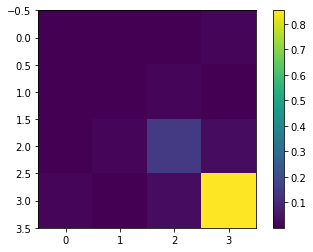

In [19]:
print(S)
print(-np.sort(-np.abs(np.diag(show_real_diag(angles, theta_weights).numpy()))))
plt.imshow(np.abs(show_real_diag(angles, theta_weights).numpy()))
plt.colorbar()
plt.show()